In [1]:
import re
import os
import pandas as pd
import random
from tqdm import tqdm 

file_paths, file_names, emotions, audios = [], [], [], []
emotion_map = {'Neutral': 'neutral', 'Anger': 'angry', 'Happiness': 'happy', 'Sadness': 'sad', 'Fear': 'fear',
              'Disgust': 'disgust'}

main_path = '/home/rl3155/Multilingual-Speech-Emotion-Recognition-System/Spanish/Spanish_New'
DATA_NATURAL = "/home/rl3155/MESD_All"

In [2]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

1.12.1
0.12.1+cu113
cuda


In [3]:
# Get the entries with assigned session

dataframe_path = '/home/rl3155/Multilingual-Speech-Emotion-Recognition-System/Spanish/session_entries.csv'
file = pd.read_csv(dataframe_path)[['path', 'name', 'emotion', 'session']]
file.head()

,path,name,emotion,session
0,/home/rl3155/MESD_All/Fear_F_A_basta_ya.wav,Fear_F_A_basta_ya.wav,fear,1
1,/home/rl3155/MESD_All/Happiness_M_A_arriba.wav,Happiness_M_A_arriba.wav,happy,1
2,/home/rl3155/MESD_All/Fear_F_B_arana.wav,Fear_F_B_arana.wav,fear,1
3,/home/rl3155/MESD_All/Neutral_M_B_articulo.wav,Neutral_M_B_articulo.wav,neutral,1
4,/home/rl3155/MESD_All/Disgust_F_A_antes.wav,Disgust_F_A_antes.wav,disgust,1


In [40]:
from tqdm import tqdm

bundle = torchaudio.pipelines.HUBERT_LARGE
extractor = bundle.get_model()

audios = []
for i in tqdm(range(len(file['path']))):
    path = file['path'][i]
    wave, sr = torchaudio.load(path)
    if sr != bundle.sample_rate:
        wave = torchaudio.functional.resample(wave, sr, bundle.sample_rate)
    with torch.inference_mode():
        feature, _ = extractor.extract_features(wave)
    feature = [f[0] for f in feature]
    audio = torch.stack(feature)
    audio = torch.mean(audio, dim=1, keepdim=False)
    audios.append(audio)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 862/862 [02:31<00:00,  5.70it/s]


### Load Data

In [16]:
class MyDataSet(torch.utils.data.Dataset):
    def __init__(self, audios, labels, label_transform):
        super(MyDataSet).__init__()
        self.audios = audios
        self.labels = labels
        self.label_transform = label_transform
        
    def __getitem__(self, idx):
        label = self.label_transform[self.labels[idx]]
        audio = self.audios[idx]
        return audio, label
    
    def __len__(self):
        return len(self.labels)

In [17]:
categories = ['neutral', 'angry', 'happy', 'sad', 'fear', 'disgust']
cate_dic = {}
for i, cate in enumerate(categories):
    cate_dic[cate] = i
cate_dic

{'neutral': 0, 'angry': 1, 'happy': 2, 'sad': 3, 'fear': 4, 'disgust': 5}

## Train with Model

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class NN(nn.Module):
    def __init__(self, vocab_size, hidden_size=128, label_size=6):
        super().__init__()
        self.nn = nn.Linear(in_features = vocab_size, out_features = hidden_size)
        self.linear = nn.Linear(in_features = hidden_size, out_features = label_size)

    def forward(self, x):
        x = self.nn(x)
        logits = self.linear(x)
        return logits

### Model Traning on each layer 

In [41]:
holdout = 1
train_emotions = list(file[file['session'] != holdout]['emotion'])
train_audios = [audios[i] for i in range(len(audios)) if file['session'][i] != holdout]
test_emotions = list(file[file['session'] == holdout]['emotion'])
test_audios = [audios[i] for i in range(len(audios)) if file['session'][i] == holdout]

In [42]:
from torch.utils.data import DataLoader
import torch.optim as optim

layers = 24
test_accuracies = []
for layer in range(layers):
    train = torch.stack([x[layer] for x in train_audios])
    test = torch.stack([x[layer] for x in test_audios])
    train_dataset = MyDataSet(train, train_emotions, cate_dic)
    trainloader_args = dict(batch_size=64, shuffle=True)
    train_dataloader = DataLoader(train_dataset, **trainloader_args)
    
    model = NN(1024)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    epochs = 50
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    for epoch in tqdm(range(epochs)):
        train_loss = 0
        acc_cnt = 0
        err_cnt = 0
        batch_cnt = 0
        model.train()
        for batch, (x, y) in enumerate(train_dataloader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.cpu().item()

            #model outputs
            out_val, out_indices = torch.max(logits, dim=1)
            tar_indices = y

            for i in range(len(out_indices)):
                if out_indices[i] == tar_indices[i]:
                    acc_cnt += 1
                else:
                    err_cnt += 1
            batch_cnt += 1

        train_loss = train_loss/batch_cnt
        train_accuracy = acc_cnt/(acc_cnt+err_cnt)
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        
    test_dataset = MyDataSet(test, test_emotions, cate_dic)
    testloader_args = dict(batch_size=1, shuffle=True)
    test_dataloader = DataLoader(test_dataset, **testloader_args)

    test_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model.eval()

    for x, y in test_dataloader:

        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = criterion(logits, y)
        test_loss += loss.cpu().item()

        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1

    test_loss = test_loss/batch_cnt
    test_accuracy = acc_cnt/(acc_cnt+err_cnt)
    print(f'layer: {layer}, test accuracy: {test_accuracy}')
    test_accuracies.append(test_accuracy)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.38it/s]


layer: 0, test accuracy: 0.7790697674418605


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.71it/s]


layer: 1, test accuracy: 0.7732558139534884


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.53it/s]


layer: 2, test accuracy: 0.7790697674418605


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.77it/s]


layer: 3, test accuracy: 0.8604651162790697


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.14it/s]


layer: 4, test accuracy: 0.7965116279069767


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.23it/s]


layer: 5, test accuracy: 0.8313953488372093


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.54it/s]


layer: 6, test accuracy: 0.6802325581395349


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.77it/s]


layer: 7, test accuracy: 0.8023255813953488


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.62it/s]


layer: 8, test accuracy: 0.6744186046511628


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.84it/s]


layer: 9, test accuracy: 0.7151162790697675


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.84it/s]


layer: 10, test accuracy: 0.6744186046511628


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.89it/s]


layer: 11, test accuracy: 0.6918604651162791


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.61it/s]


layer: 12, test accuracy: 0.7325581395348837


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.04it/s]


layer: 13, test accuracy: 0.7325581395348837


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.89it/s]


layer: 14, test accuracy: 0.5755813953488372


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.60it/s]


layer: 15, test accuracy: 0.6744186046511628


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.91it/s]


layer: 16, test accuracy: 0.6453488372093024


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.79it/s]


layer: 17, test accuracy: 0.6337209302325582


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.91it/s]


layer: 18, test accuracy: 0.5348837209302325


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.57it/s]


layer: 19, test accuracy: 0.45930232558139533


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.20it/s]


layer: 20, test accuracy: 0.5872093023255814


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.86it/s]


layer: 21, test accuracy: 0.5290697674418605


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.12it/s]


layer: 22, test accuracy: 0.4418604651162791


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.81it/s]


layer: 23, test accuracy: 0.622093023255814


### Plots

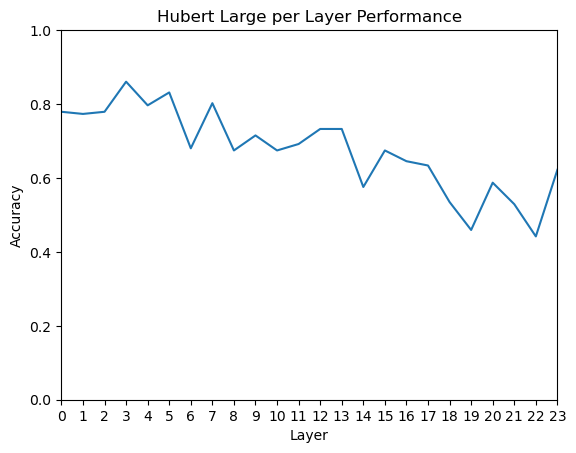

In [43]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(range(layers), test_accuracies)
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.axis([0, layers-1, 0, 1])
plt.xticks(np.arange(0, layers, 1))
plt.title("Hubert Large per Layer Performance")
plt.show()

In [44]:
res = pd.DataFrame({'layer': range(layers), 'accuracy': test_accuracies})
res.to_csv(main_path + '/results/hubertlarge_perlayer.csv', index=False)
res

,layer,accuracy
0,0,0.779070
1,1,0.773256
2,2,0.779070
3,3,0.860465
4,4,0.796512
5,5,0.831395
6,6,0.680233
7,7,0.802326
8,8,0.674419
9,9,0.715116
